# 1. Подготовка датасета

На данном этапе производится загрузка и предварительная обработка датасетов для задачи детекции фишинговых email сообщений. Используются два датасета:
- **Nazario Phishing Corpus** (2015-2024) - коллекция фишинговых писем
- **Enron Email Dataset** - коллекция легитимных писем

**Важно**: Парсинг email, извлечение признаков и другие операции выполняются через модули системы (`src/email_parser.py`, `src/feature_extractor.py` и т.д.). В данном блокноте выполняется только загрузка и подготовка сырых данных.




In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Добавляем родительскую директорию в sys.path для импорта модулей как пакета
# Это позволяет использовать относительные импорты в модулях (например, .utils)
BASE_DIR = Path('../').resolve()
if str(BASE_DIR) not in sys.path:
    sys.path.insert(0, str(BASE_DIR))

# Настройка путей
DATA_RAW = BASE_DIR / 'data' / 'raw'
DATA_PROCESSED = BASE_DIR / 'data' / 'processed'

print(f"Рабочая директория: {BASE_DIR}")
print(f"Исходные данные: {DATA_RAW}")
print(f"Обработанные данные: {DATA_PROCESSED}")
print(f"sys.path содержит: {BASE_DIR}")


Рабочая директория: C:\Users\huzch\Documents\project\eml-phishing-analyzer
Исходные данные: C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\raw
Обработанные данные: C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\processed
sys.path содержит: C:\Users\huzch\Documents\project\eml-phishing-analyzer


## 2. Загрузка Nazario Phishing Corpus

Nazario Phishing Corpus представляет из себя отдельные файлы с письмами за период 2015-2024. Файлы представлены в текстовом формате, письма начинаются с "From " и разделены пустой строкой.

In [ ]:
def split_nazario_file(file_path: Path) -> list:
    """
    Разделяет файл Nazario на отдельные email сообщения.
    
    Args:
        file_path: Путь к файлу
        
    Returns:
        list: Список строк с содержимым каждого email
    """
    emails = []
    current_email = []
    
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            # Проверяем, начинается ли строка с "From " (начало нового письма)
            if line.startswith('From ') and len(line) > 20 and '@' in line:
                if current_email:
                    emails.append(''.join(current_email))
                current_email = [line]
            else:
                current_email.append(line)
        
        # Добавляем последнее письмо
        if current_email:
            emails.append(''.join(current_email))
    
    return emails


# Загрузка Nazario Phishing Corpus (2015-2024)
nazario_path = DATA_RAW / 'nazario'
nazario_files = sorted(nazario_path.glob('phishing-*.txt'))

print(f"Найдено файлов Nazario: {len(nazario_files)}")
for f in nazario_files:
    print(f"  - {f.name}")

# Объединение всех файлов
all_nazario_emails = []
for file_path in tqdm(nazario_files, desc="Загрузка Nazario файлов"):
    emails = split_nazario_file(file_path)
    all_nazario_emails.extend(emails)
    print(f"  {file_path.name}: {len(emails)} писем")

print(f"\nВсего загружено фишинговых писем: {len(all_nazario_emails)}")


Выведем несколько писем для проверки корректной обработки датасета.

In [ ]:
emails_nazario_example = all_nazario_emails[:5]
emails_nazario_example

### 2.1 Сохранение Nazario датасета

После загрузки Nazario датасет сохраняется в структурированном формате (CSV) для дальнейшей обработки.


In [ ]:
# Сохранение в DataFrame для дальнейшей обработки
print("Создание DataFrame для Nazario датасета...")
df_nazario = pd.DataFrame({
    'email_content': all_nazario_emails,
    'label': 1 # фишинговое письмо
})


In [ ]:
df_nazario.head()

In [ ]:
print(f"Размер датасета Nazario: {len(df_nazario)}")
print(f"Распределение меток: {df_nazario['label'].value_counts().to_dict()}")

In [ ]:
# Сохранение Nazario в CSV
print("\nСохранение Nazario датасета в CSV...")
nazario_csv_path = DATA_PROCESSED / 'nazario_raw.csv'
with tqdm(total=1, desc="Сохранение файла", unit="файл", 
          colour='#A23B72', ncols=100, 
          bar_format='{l_bar}{bar}| {elapsed}<{remaining}') as pbar:
    df_nazario.to_csv(nazario_csv_path, index=False)
    pbar.update(1)

print(f"Nazario датасет сохранен: {nazario_csv_path}")

## 3. Загрузка Enron Email Dataset

Enron Email Dataset содержит легитимные письма. Файл представлен в формате CSV. После загрузки будет выполнено сравнение размеров с Nazario датасетом и балансировка при необходимости.


In [ ]:
# Определение структуры Enron файла
enron_path = DATA_RAW / 'enron' / 'emails.csv'

# Читаем первые строки для понимания структуры
sample_df = pd.read_csv(enron_path).head()
print(f"Столбцы Enron: {sample_df.columns.tolist()}")
print(f"\nПример данных:")
print(sample_df)

# Определяем столбец с содержимым email
email_content_col = 'message'
print(f"\nИспользуется столбец: {email_content_col}")


In [ ]:
# Загрузка Enron (по частям из-за большого размера)
chunk_size = 10000
enron_data = []

# Загружаем все доступные данные 
for chunk in tqdm(pd.read_csv(enron_path, chunksize=chunk_size), desc="Чтение Enron"):
    # Берем только нужный столбец
    chunk_emails = chunk[[email_content_col]].copy()
    chunk_emails.columns = ['email_content']
    enron_data.append(chunk_emails)

df_enron_raw = pd.concat(enron_data, ignore_index=True)

print(f"\nЗагружено легитимных писем: {len(df_enron_raw)}")


In [ ]:
# Уменьшение размера Enron до 2950 строк для балансировки
import random
target_size = 2950
print(f"Уменьшение размера Enron с {len(df_enron_raw)} до {target_size} строк...")
random.seed(42)
df_enron_raw = df_enron_raw.sample(n=target_size, random_state=42).reset_index(drop=True)
print(f"Размер после уменьшения: {len(df_enron_raw)}")


### 3.1 Сохранение Enron датасета

После загрузки Enron датасет сохраняется в структурированном формате (CSV) для дальнейшей обработки.


In [ ]:
# Сохранение в DataFrame для дальнейшей обработки
print("Создание DataFrame для Enron датасета...")
df_enron = pd.DataFrame({
    'email_content': df_enron_raw['email_content'],
    'label': 0  # легитимное письмо
})

In [ ]:
df_enron.head()


In [ ]:
print(f"Размер датасета Enron: {len(df_enron)}")
print(f"Распределение меток: {df_enron['label'].value_counts().to_dict()}")


In [ ]:
# Сохранение Enron в CSV
print("\nСохранение Enron датасета в CSV...")
enron_csv_path = DATA_PROCESSED / 'enron_raw.csv'
with tqdm(total=1, desc="Сохранение файла", unit="файл", 
          colour='#A23B72', ncols=100, 
          bar_format='{l_bar}{bar}| {elapsed}<{remaining}') as pbar:
    df_enron.to_csv(enron_csv_path, index=False)
    pbar.update(1)

print(f"Enron датасет сохранен: {enron_csv_path}")

In [ ]:
# Сравнение размеров датасетов
nazario_size = len(df_nazario)
enron_size = len(df_enron)

print(f"Размер Nazario (phishing): {nazario_size}")
print(f"Размер Enron (legitimate): {enron_size}")
print(f"Разница: {abs(nazario_size - enron_size)}")

# Балансировка: привести оба датасета к минимальному размеру
min_size = min(nazario_size, enron_size)
if nazario_size != enron_size:
    print(f"\nБалансировка датасетов до минимального размера ({min_size})...")
    df_nazario = df_nazario.sample(n=min_size, random_state=42).reset_index(drop=True)
    df_enron = df_enron.sample(n=min_size, random_state=42).reset_index(drop=True)
    print(f"Размер Nazario после балансировки: {len(df_nazario)}")
    print(f"Размер Enron после балансировки: {len(df_enron)}")
else:
    print("\nРазмеры датасетов уже сбалансированы.")

print(f"\nФинальные размеры:")
print(f"  Nazario (phishing): {len(df_nazario)}")
print(f"  Enron (legitimate): {len(df_enron)}")


## 4. Объединение датасетов

Объединение фишинговых и легитимных писем в единый датасет для дальнейшей обработки модулями системы.


In [ ]:
# Объединение Nazario и Enron в общий датафрейм
df = pd.concat([df_nazario, df_enron], ignore_index=True)

### 4.1 Проверка и очистка данных

In [2]:
df = pd.read_csv(DATA_PROCESSED / 'email_dataset.csv')

In [3]:

# Подсчёт количества пустых значений и дублей до очистки
num_na = df['email_content'].isnull().sum()
num_dupes = df.duplicated().sum()
print(f"Пустых email_content: {num_na}")
print(f"Дубликатов: {num_dupes}")

# Очистка: удаляем пустые и дубликаты
df = df.dropna(subset=['email_content']).drop_duplicates().reset_index(drop=True)

print(f"Размер после очистки: {df.shape}")

print("\nФинальное распределение классов:")
print(df['label'].value_counts())

Пустых email_content: 0
Дубликатов: 0
Размер после очистки: (5900, 2)

Финальное распределение классов:
label
1    2950
0    2950
Name: count, dtype: int64


In [4]:
df.head()

,email_content,label
0,From jose@monkey.org Thu Aug 17 11:41:23 2023 ...,1
1,From jose@monkey.org Fri Sep 27 15:46:37 2024 ...,1
2,From jose@monkey.org Mon Apr 20 11:26:14 2020 ...,1
3,From jose@monkey.org Thu Sep 21 19:14:02 2017 ...,1
4,From jose@monkey.org Wed May 3 17:20:00 2017 ...,1


In [5]:
df.tail()

,email_content,label
5895,Message-ID: <17702800.1075856096893.JavaMail.e...,0
5896,Message-ID: <16654602.1075840221753.JavaMail.e...,0
5897,Message-ID: <21859410.1075852282055.JavaMail.e...,0
5898,Message-ID: <11613616.1075849659137.JavaMail.e...,0
5899,Message-ID: <19463108.1075852096010.JavaMail.e...,0


In [6]:
# Сохранение итогового датасета
output_path = DATA_PROCESSED / 'email_dataset.csv'
df.to_csv(output_path, index=False)
print(f"Итоговый датасет сохранён в {output_path}")

Итоговый датасет сохранён в C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\processed\email_dataset.csv


In [7]:
# Подсчёт количества пустых значений и дублей до очистки
num_na = df['email_content'].isnull().sum()
num_dupes = df.duplicated().sum()
print(f"Пустых строк: {num_na}")
print(f"Дубликатов: {num_dupes}")


print("Размерность после очистки:", df.shape)


Пустых строк: 0
Дубликатов: 0
Размерность после очистки: (5900, 2)


## 5. Парсинг email сообщений

На данном этапе производится парсинг каждого email сообщения с использованием модуля `email_parser`. 
Извлекаются заголовки, тело письма, вложения, URL и домены.


In [4]:
# Импорт модулей для обработки
# Родительская директория добавлена в sys.path, поэтому src доступен как пакет
import importlib
from src.email_parser import parse_email
from src.translation import Translator
from src.url_domain_analyzer import analyze_urls_and_domains

# Импорт и перезагрузка модуля translation для применения последних изменений
import src.translation as translation_module
importlib.reload(translation_module)
from src.translation import Translator

# Импорт и перезагрузка модуля feature_extractor для применения последних изменений
import src.feature_extractor as fe_module
importlib.reload(fe_module)
from src.feature_extractor import FeatureExtractor

import pickle
from sklearn.model_selection import train_test_split

# Инициализация компонентов
translator = Translator()
feature_extractor = FeatureExtractor(max_features=5000)


In [5]:
# Парсинг всех email сообщений
print("Начало парсинга email сообщений...")
parsed_emails = []
invalid_indices = []  # Индексы писем с ошибками парсинга 
initial_count = len(df)

for idx, email_content in tqdm(enumerate(df['email_content']), total=len(df), desc="Парсинг писем"):
    try:
        parsed = parse_email(str(email_content))
        parsed_emails.append(parsed)
    except Exception as e:
        # В случае ошибки парсинга сохраняем индекс для удаления
        invalid_indices.append(idx)
        print(f"Ошибка парсинга письма {idx}: {str(e)[:100]}... Письмо будет удалено из датасета.")

# Удаляем письма с ошибками парсинга из датасета 
if invalid_indices:
    df = df.drop(df.index[invalid_indices]).reset_index(drop=True)

print(f"\nПарсинг завершен. Успешно обработано писем: {len(parsed_emails)}")
print(f"Удалено писем с ошибками: {len(invalid_indices)} ({len(invalid_indices)/initial_count*100:.2f}%)")


Начало парсинга email сообщений...


Парсинг писем:  11%|█         | 641/5900 [00:15<02:02, 42.97it/s]

Ошибка парсинга письма 638: unknown encoding: utf-8message-id: <1571316602-94a08da1fecbb6e8b46990538c7b50b2-94a08da1fecbb6e8b469... Письмо будет удалено из датасета.


Парсинг писем:  42%|████▏     | 2452/5900 [01:42<01:52, 30.58it/s]

Ошибка парсинга письма 2444: unknown encoding: utf-8x-priority: 3... Письмо будет удалено из датасета.


Парсинг писем: 100%|██████████| 5900/5900 [03:40<00:00, 26.81it/s]


Парсинг завершен. Успешно обработано писем: 5898
Удалено писем с ошибками: 2 (0.03%)


## 6. Перевод текста писем

Перевод русскоязычных писем на английский язык для единообразной обработки. 
Англоязычные письма остаются без изменений.


In [6]:
# Перевод всех писем
print("Начало перевода писем...")
translated_texts = []
translated_count = 0  # Счетчик переведенных писем

prepare_text_func = FeatureExtractor.prepare_text_from_parsed_email

for parsed_email in tqdm(parsed_emails, desc="Перевод писем"):
    try:
        clean_text = prepare_text_func(parsed_email)
        detected_language = translator.detect_language(clean_text) if clean_text else 'en'
        translated = translator.translate_text(clean_text)
        if detected_language == 'ru':
            translated_count += 1
        translated_texts.append(translated)
    except Exception as e:
        print(f"Ошибка перевода: {e}")
        subject = parsed_email.get('subject', '') or ''
        body = parsed_email.get('body_plain', '') or ''
        if not body:
            body = parsed_email.get('body_html', '') or ''
        translated_texts.append(f"{subject} {body}".strip())

print(f"\nПеревод завершен. Обработано писем: {len(translated_texts)}")
print(f"Действительно переведено с русского на английский: {translated_count}")
print(f"Писем на английском (не требовали перевода): {len(translated_texts) - translated_count}")


Начало перевода писем...


Перевод писем: 100%|██████████| 5898/5898 [02:11<00:00, 44.80it/s]


Перевод завершен. Обработано писем: 5898
Действительно переведено с русского на английский: 1
Писем на английском (не требовали перевода): 5897


## 7. Анализ URL и доменов

Анализ URL-адресов и доменов для выявления подозрительных паттернов:
- URL-shorteners
- Длинные домены
- Подозрительные TLD
- IP-адреса в URL


In [7]:
# Анализ URL и доменов для каждого письма
print("Начало анализа URL и доменов...")
url_analyses = []

for parsed_email in tqdm(parsed_emails, desc="Анализ URL/доменов"):
    try:
        analysis = analyze_urls_and_domains(parsed_email)
        url_analyses.append(analysis)
    except Exception as e:
        # В случае ошибки создаем пустой анализ
        print(f"Ошибка анализа URL/доменов: {e}")
        url_analyses.append({
            'has_url_shortener': False,
            'has_long_domain': False,
            'has_suspicious_tld': False,
            'has_ip_in_url': False
        })

print(f"\nАнализ URL/доменов завершен. Обработано: {len(url_analyses)}")


Начало анализа URL и доменов...


Анализ URL/доменов: 100%|██████████| 5898/5898 [00:00<00:00, 13969.15it/s]


Анализ URL/доменов завершен. Обработано: 5898


In [8]:
# Найти письмо с темой "REGISTER YOUR ACCOUNT ON THE NEW USAA PORTAL NOW" и вывести его номер (индекс) и само письмо

subject_to_find = "REGISTER YOUR ACCOUNT ON THE NEW USAA PORTAL NOW"
found = False
for i, parsed_email in enumerate(parsed_emails):
    subject = parsed_email.get('subject', '') or ''
    if subject.strip().upper() == subject_to_find.upper():
        print(f"Найдено письмо на позиции {i} с темой:\n{subject}\n")
        print("Полное письмо ниже:")
        print(df.iloc[i]['email_content'])
        found = True
        break
if not found:
    print("Письмо с данной темой не найдено в датасете.")

Найдено письмо на позиции 80 с темой:
REGISTER YOUR ACCOUNT ON THE NEW USAA PORTAL NOW

Полное письмо ниже:
From jose@monkey.org Sat Feb  6 17:42:39 2016 +0000
Return-Path: newportalsite@us.af.mil
Delivered-To: jose@monkey.org
X-FDA: 71158745238.06.jeans76_50c3a8324dc01
Authentication-Results: auth.b.hostedemail.com; dkim=none
	reason="no signature"; dkim-adsp=none (insecure policy);
	dkim-atps=neutral
X-Spam-Summary: 30,2,0,d41d8cd98f00b204,d41d8cd98f00b204,newportalsite@us.af.mil,:newportalsite@us.af.mil,RULES_HIT:41:327:355:379:581:871:988:989:1260:1261:1313:1314:1345:1381:1516:1517:1518:1522:1536:1575:1594:1692:1699:1711:1730:1748:1764:1766:1792:2392:2393:2559:2562:3138:3139:3140:3141:3142:3876:3877:4699:5007:6114:6264:6618:6642:6687:6748:7281:7398:10004:10400:11604:11658:11914:12166:12340:12561:13110:14129:14515:21080:30001:30026:30054:30055,0,RBL:88.37.118.242:@us.af.mil:.lbl8.mailshell.net-62.16.122.100 64.201.201.201,CacheIP:none,Bayesian:0.5,0.5,0.5,Netcheck:none,DomainCache:0

## 8. Извлечение признаков

На данном этапе производится:
1. Обучение TF-IDF векторизатора на всех переведенных текстах
2. Извлечение синтетических признаков для каждого письма
3. Объединение TF-IDF векторов и синтетических признаков в финальные feature vectors


### 8.2 Создание датафрейма с признаками

Перед векторизацией создаем датафрейм со всеми признаками, которые будут использоваться для машинного обучения.


In [ ]:
## Анализ корреляций признаков с целевой переменной

Анализ корреляций между признаками и классом (label) для выявления признаков, которые могут привести к переобучению модели.


,correlation,p_value,abs_correlation
has_long_domain,0.484301,0.000000e+00,0.484301
urgency_markers_count,0.452126,3.811150e-295,0.452126
url_count,0.325606,1.044891e-145,0.325606
subject_length,0.271920,1.709515e-100,0.271920
attachment_count,0.236093,1.632048e-75,0.236093
has_url_shortener,0.167043,3.621899e-38,0.167043
has_suspicious_tld,0.123112,2.334309e-21,0.123112
body_length,0.068568,1.356560e-07,0.068568
has_ip_in_url,0.013071,3.155448e-01,0.013071
ip_count,0.000020,9.987692e-01,0.000020


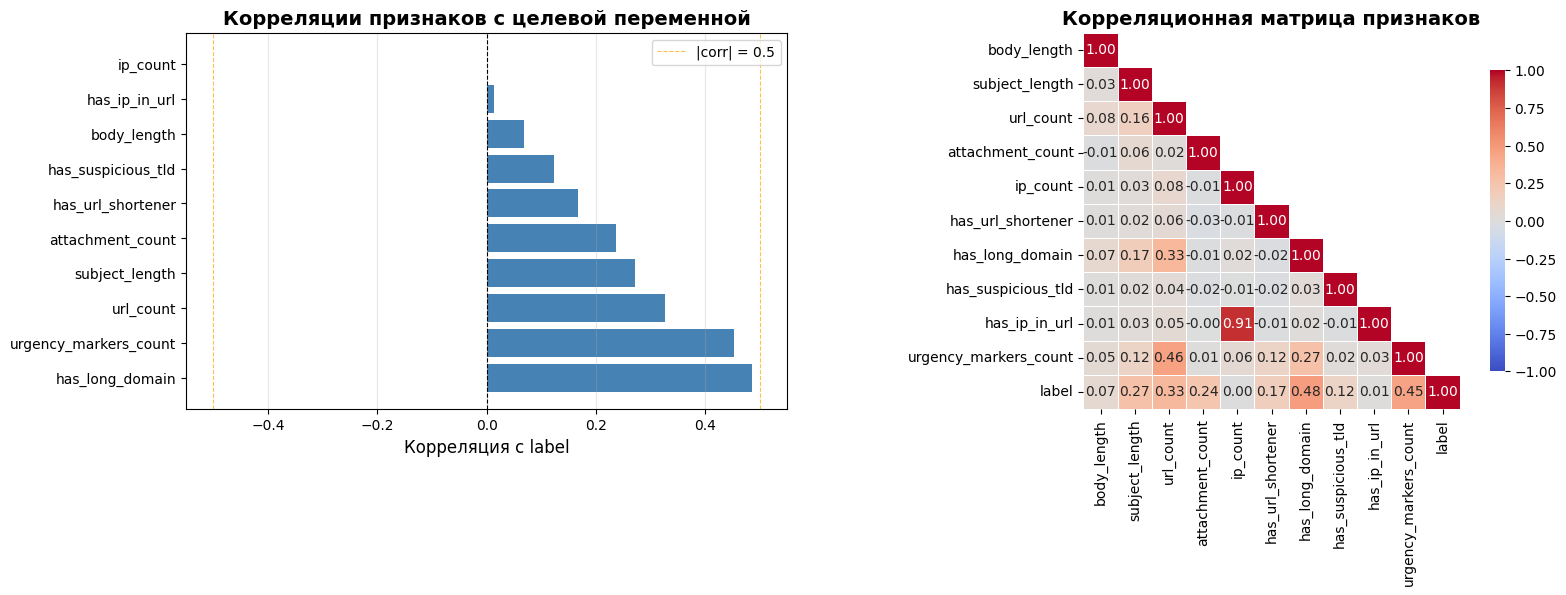


АНАЛИЗ МУЛЬТИКОЛЛИНЕАРНОСТИ (корреляции между признаками)

Признаки с высокой корреляцией между собой (|correlation| > 0.7):
--------------------------------------------------------------------------------


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr

# Настройка визуализации
plt.style.use('default')
sns.set_palette("husl")

numeric_features = [
    'body_length', 'subject_length', 'url_count', 'attachment_count', 
    'ip_count', 'has_url_shortener', 'has_long_domain', 
    'has_suspicious_tld', 'has_ip_in_url', 'urgency_markers_count'
]

# Вычисляем корреляции с целевой переменной (label)
correlations = {}
for feature in numeric_features:
    if feature in df_features.columns:
        # Используем point-biserial correlation для корреляции между непрерывной и бинарной переменной
        corr, p_value = pointbiserialr(df_features[feature], df_features['label'])
        correlations[feature] = {
            'correlation': corr,
            'p_value': p_value,
            'abs_correlation': abs(corr)
        }

# Создаем DataFrame с результатами
corr_df = pd.DataFrame(correlations).T
corr_df = corr_df.sort_values('abs_correlation', ascending=False)

display(corr_df)

# Визуализация корреляций
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График 1: Барплот корреляций
ax1 = axes[0]
colors = ['red' if abs(corr_df.loc[feat, 'correlation']) > 0.5 else 'steelblue' 
          for feat in corr_df.index]
ax1.barh(corr_df.index, corr_df['correlation'], color=colors)
ax1.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
ax1.axvline(x=0.5, color='orange', linestyle='--', linewidth=0.8, alpha=0.7, label='|corr| = 0.5')
ax1.axvline(x=-0.5, color='orange', linestyle='--', linewidth=0.8, alpha=0.7)
ax1.set_xlabel('Корреляция с label', fontsize=12)
ax1.set_title('Корреляции признаков с целевой переменной', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# График 2: Тепловая карта корреляций между признаками
ax2 = axes[1]
feature_matrix = df_features[numeric_features + ['label']]
correlation_matrix = feature_matrix.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, mask=mask, square=True, 
            linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax2)
ax2.set_title('Корреляционная матрица признаков', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Анализ мультиколлинеарности (высокая корреляция между признаками)
print("\n" + "=" * 80)
print("АНАЛИЗ МУЛЬТИКОЛЛИНЕАРНОСТИ (корреляции между признаками)")
print("=" * 80)
print("\nПризнаки с высокой корреляцией между собой (|correlation| > 0.7):")
print("-" * 80)


In [13]:
# Создание датафрейма со всеми признаками перед векторизацией
print("Создание датафрейма с признаками...")

features_data = []

for idx, (parsed_email, translated_text, url_analysis) in enumerate(tqdm(
    zip(parsed_emails, translated_texts, url_analyses),
    total=len(parsed_emails),
    desc="Сбор признаков для датафрейма"
)):
    try:
        # Используем extract_all_features для получения synthetic_features_dict
        # Если векторизатор не обучен, используем отдельные методы
        if feature_extractor.is_fitted:
            # Векторизатор обучен - используем extract_all_features
            features = feature_extractor.extract_all_features(
                parsed_email,
                translated_text,
                url_analysis
            )
            synthetic_features = features['synthetic_features']
        else:
            quantitative_norm, quantitative_raw = feature_extractor.extract_quantitative_features(parsed_email)
            structural_norm, structural_raw = feature_extractor.extract_structural_features(parsed_email)
            binary = feature_extractor.extract_binary_indicators(url_analysis, parsed_email)
            linguistic_norm, linguistic_raw = feature_extractor.extract_linguistic_features(translated_text)
            
            # Формируем synthetic_features_dict вручную
            synthetic_features = {
                'quantitative': {
                    'url_count': int(quantitative_raw[0]),
                    'attachment_count': int(quantitative_raw[1]),
                    'ip_count': int(quantitative_raw[2])
                },
                'structural': {
                    'subject_length': int(structural_raw[0]),
                    'body_length': int(structural_raw[1])
                },
                'binary': {
                    'has_url_shortener': int(binary[0]),
                    'has_long_domain': int(binary[1]),
                    'has_suspicious_tld': int(binary[2]),
                    'has_ip_in_url': int(binary[3])
                },
                'linguistic': {
                    'urgency_markers_count': int(linguistic_raw[0])
                }
            }
        
        # Предобработка текста 
        preprocessed_text = feature_extractor.preprocess_text(translated_text)
        
        # Используем synthetic_features_dict для заполнения датафрейма
        features_data.append({
            'email_content': df.iloc[idx]['email_content'][:100] + '...' if len(df.iloc[idx]['email_content']) > 100 else df.iloc[idx]['email_content'],
            'preprocessed_text': preprocessed_text,
            'body_length': synthetic_features['structural']['body_length'],
            'subject_length': synthetic_features['structural']['subject_length'],
            'url_count': synthetic_features['quantitative']['url_count'],
            'attachment_count': synthetic_features['quantitative']['attachment_count'],
            'ip_count': synthetic_features['quantitative']['ip_count'],
            'has_url_shortener': synthetic_features['binary']['has_url_shortener'],
            'has_long_domain': synthetic_features['binary']['has_long_domain'],
            'has_suspicious_tld': synthetic_features['binary']['has_suspicious_tld'],
            'has_ip_in_url': synthetic_features['binary']['has_ip_in_url'],
            'urgency_markers_count': synthetic_features['linguistic']['urgency_markers_count'],
            'label': df.iloc[idx]['label']
        })
    except Exception as e:
        print(f"Ошибка сбора признаков для письма {idx}: {e}")
        try:
            preprocessed_text = feature_extractor.preprocess_text(translated_text) if translated_text else ''
        except:
            preprocessed_text = ''
        
        features_data.append({
            'email_content': df.iloc[idx]['email_content'][:100] + '...' if len(df.iloc[idx]['email_content']) > 100 else df.iloc[idx]['email_content'],
            'preprocessed_text': preprocessed_text,
            'body_length': 0,
            'subject_length': 0,
            'url_count': 0,
            'attachment_count': 0,
            'ip_count': 0,
            'has_url_shortener': 0,
            'has_long_domain': 0,
            'has_suspicious_tld': 0,
            'has_ip_in_url': 0,
            'urgency_markers_count': 0,
            'label': df.iloc[idx]['label']
        })

# Создание датафрейма
df_features = pd.DataFrame(features_data)

print(f"\nДатафрейм с признаками создан. Размер: {df_features.shape}")
print("\nПервые 10 строк датафрейма:")
display(df_features.head(10))

Создание датафрейма с признаками...


Сбор признаков для датафрейма:   0%|          | 0/5898 [00:00<?, ?it/s]

Сбор признаков для датафрейма: 100%|██████████| 5898/5898 [00:44<00:00, 131.88it/s]



Датафрейм с признаками создан. Размер: (5898, 13)

Первые 10 строк датафрейма:


,email_content,preprocessed_text,body_length,subject_length,url_count,attachment_count,ip_count,has_url_shortener,has_long_domain,has_suspicious_tld,has_ip_in_url,urgency_markers_count,label
0,From jose@monkey.org Thu Aug 17 11:41:23 2023 ...,account policy important account notification ...,11931,66,1,0,0,0,0,0,0,3,1
1,From jose@monkey.org Fri Sep 27 15:46:37 2024 ...,payment receipt please review attached payment...,73,16,0,1,0,0,0,0,0,0,1
2,From jose@monkey.org Mon Apr 20 11:26:14 2020 ...,nedbank current account statement click read n...,2717,51,20,1,0,0,0,0,0,16,1
3,From jose@monkey.org Thu Sep 21 19:14:02 2017 ...,receipt apple receipt apple jose billed applei...,35442,24,3,0,0,0,0,0,0,0,1
4,From jose@monkey.org Wed May 3 17:20:00 2017 ...,incoming fund transfer confirmation alert dear...,623,42,1,0,0,0,0,0,0,3,1
5,From jose@monkey.org Fri Nov 22 16:45:42 2024 ...,unusual login attempt jose unusual login attem...,14503,46,1,0,0,0,0,0,0,0,1
6,From jose@monkey.org Mon Apr 11 12:43:36 2016 ...,password expire day please click link validate...,590,30,1,0,0,0,0,0,0,2,1
7,From jose@monkey.org Wed Nov 29 18:00:57 2023 ...,item shared banned access online due unauthori...,288,91,8,0,0,0,0,0,0,4,1
8,From jose@monkey.org Thu Feb 23 02:00:46 2017 ...,email blacklisted email blacklisted dear jose ...,576,17,1,0,0,0,1,0,0,9,1
9,From jose@monkey.org Thu Mar 23 09:22:25 2023 ...,spam sharepoint send file review approval plea...,3545,61,5,0,0,0,1,0,0,0,1


In [14]:
from collections import Counter

def analyze_top_words_by_class(preprocessed_phishing, preprocessed_legitimate, top_n=50, class_ratio=0.3, other_ratio=0.05):
    """
    Находит слова, характерные только для одного класса (фишинг или легит), и топовые слова в каждом классе.
    Использует уже предобработанные тексты из df_features (preprocessed_text).
    """
    # Разбиваем предобработанные тексты на слова (preprocessed_text уже содержит обработанные слова через пробелы)
    phishing_words = []
    for processed_text in preprocessed_phishing:
        if processed_text and isinstance(processed_text, str):
            phishing_words.extend(processed_text.split())
    
    legitimate_words = []
    for processed_text in preprocessed_legitimate:
        if processed_text and isinstance(processed_text, str):
            legitimate_words.extend(processed_text.split())
    
    phishing_freq = Counter(phishing_words)
    legitimate_freq = Counter(legitimate_words)
    
    n_phishing = len(preprocessed_phishing)
    n_legitimate = len(preprocessed_legitimate)
    
    print(f"\n Анализ частоты слов (по предобработанным текстам из df_features)")
    print(f"Фишинговых писем: {n_phishing}")
    print(f"Легитимных писем: {n_legitimate}")
    
    phishing_specific = []
    legitimate_specific = []
    
    # Слова, специфичные для фишинга
    for word, count in phishing_freq.most_common(top_n * 2):  # Берем больше, чтобы учесть фильтрацию
        if len(word) < 3: continue
        phishing_ratio = count / n_phishing if n_phishing else 0
        legit_ratio = legitimate_freq.get(word, 0) / n_legitimate if n_legitimate else 0
        if phishing_ratio > class_ratio and legit_ratio < other_ratio:
            phishing_specific.append({
                'word': word,
                'phishing_ratio': phishing_ratio,
                'legitimate_ratio': legit_ratio,
                'phishing_count': count
            })
        if len(phishing_specific) >= top_n:
            break

    # Слова, специфичные для легитимных
    for word, count in legitimate_freq.most_common(top_n * 2):  # Берем больше, чтобы учесть фильтрацию
        if len(word) < 3: continue
        legit_ratio = count / n_legitimate if n_legitimate else 0
        phishing_ratio = phishing_freq.get(word, 0) / n_phishing if n_phishing else 0
        if legit_ratio > class_ratio and phishing_ratio < other_ratio:
            legitimate_specific.append({
                'word': word,
                'legitimate_ratio': legit_ratio,
                'phishing_ratio': phishing_ratio,
                'legitimate_count': count
            })
        if len(legitimate_specific) >= top_n:
            break

    phishing_df = pd.DataFrame(phishing_specific).sort_values('phishing_ratio', ascending=False)
    legitimate_df = pd.DataFrame(legitimate_specific).sort_values('legitimate_ratio', ascending=False)
    return phishing_df, legitimate_df, phishing_freq, legitimate_freq

# Разделение предобработанных текстов по классам из df_features
phishing_preprocessed = df_features[df_features['label'] == 1]['preprocessed_text'].tolist()
legitimate_preprocessed = df_features[df_features['label'] == 0]['preprocessed_text'].tolist()

# Анализ с использованием предобработанных текстов из df_features
phishing_df, legitimate_df, phishing_freq, legitimate_freq = analyze_top_words_by_class(
    phishing_preprocessed, legitimate_preprocessed, top_n=100)

display(phishing_df.head(20))

display(legitimate_df.head(20))




 Анализ частоты слов (по предобработанным текстам из df_features)
Фишинговых писем: 2948
Легитимных писем: 2950


,word,phishing_ratio,legitimate_ratio,phishing_count
0,jose,1.133311,0.014237,3341
1,usaa,0.654342,0.000000,1929
2,dear,0.629579,0.038983,1856
3,verify,0.368385,0.012203,1086
4,password,0.367707,0.046441,1084
5,mailbox,0.321574,0.010847,948


,word,legitimate_ratio,phishing_ratio,legitimate_count
0,enron,1.857627,0.000000,5480
1,ect,0.956949,0.002035,2823
2,power,0.755254,0.003731,2228
3,energy,0.747458,0.000339,2205
4,said,0.520000,0.004749,1534
5,market,0.487458,0.008480,1438
6,gas,0.443051,0.002714,1307
7,price,0.439661,0.012890,1297
8,state,0.398983,0.035617,1177
9,year,0.370169,0.028833,1092


In [15]:
# Обучение TF-IDF векторизатора на всех текстах
print("Обучение TF-IDF векторизатора...")
feature_extractor.fit_vectorizer(translated_texts)
print(f"TF-IDF векторизатор обучен. Размер словаря: {len(feature_extractor.tfidf_vectorizer.vocabulary_)}")


Обучение TF-IDF векторизатора...
TF-IDF векторизатор обучен. Размер словаря: 5000


In [16]:
# Извлечение синтетических признаков для обучения scaler
print("Извлечение синтетических признаков для обучения scaler...")
synthetic_features_list = []
feature_size = None  # Размер вектора признаков 

for parsed_email, translated_text, url_analysis in tqdm(
    zip(parsed_emails, translated_texts, url_analyses), 
    total=len(parsed_emails),
    desc="Извлечение синтетических признаков"
):
    try:
        # Извлекаем синтетические признаки напрямую (до MinMax нормализации)
        quantitative_norm, _ = feature_extractor.extract_quantitative_features(parsed_email)
        structural_norm, _ = feature_extractor.extract_structural_features(parsed_email)
        binary = feature_extractor.extract_binary_indicators(url_analysis, parsed_email)  
        linguistic_norm, _ = feature_extractor.extract_linguistic_features(translated_text)
        
        synthetic_features_array = np.concatenate([
            quantitative_norm, 
            structural_norm, 
            binary, 
            linguistic_norm
        ])
        
        # Сохраняем размер вектора признаков из первого успешного примера
        if feature_size is None:
            feature_size = len(synthetic_features_array)
        
        synthetic_features_list.append(synthetic_features_array)
    except Exception as e:
        error_count += 1
        if error_count <= 5:  
            print(f"Ошибка извлечения признаков: {e}")
        
        # Создаем нулевой вектор синтетических признаков правильного размера
        if feature_size is None:
            feature_size = 10
        synthetic_features_list.append(np.zeros(feature_size, dtype=np.float32))

if not synthetic_features_list:
    raise ValueError("Не удалось извлечь ни одного признака. Проверьте данные.")

# Обучение MinMaxScaler на синтетических признаках
feature_extractor.fit_scaler(synthetic_features_list)
print(f"MinMaxScaler для синтетических признаков обучен на {len(synthetic_features_list)} образцах.")
print(f"Размерность синтетических признаков: {feature_size}")

Извлечение синтетических признаков для обучения scaler...


Извлечение синтетических признаков: 100%|██████████| 5898/5898 [00:21<00:00, 272.96it/s]

MinMaxScaler для синтетических признаков обучен на 5898 образцах.
Размерность синтетических признаков: 10


In [17]:
# Извлечение финальных feature vectors для всех писем
print("Извлечение финальных feature vectors...")
X_features = []
y_labels = []

for idx, (parsed_email, translated_text, url_analysis) in enumerate(tqdm(
    zip(parsed_emails, translated_texts, url_analyses),
    total=len(parsed_emails),
    desc="Создание feature vectors"
)):
    try:
        features = feature_extractor.extract_all_features(
            parsed_email,
            translated_text,
            url_analysis
        )
        X_features.append(features['feature_vector'])
        y_labels.append(df.iloc[idx]['label'])
    except Exception as e:
        print(f"Ошибка создания feature vector для письма {idx}: {e}")
        # Создаем нулевой вектор признаков
        X_features.append(np.zeros(feature_extractor.tfidf_vectorizer.max_features + 10, dtype=np.float32))
        y_labels.append(df.iloc[idx]['label'])

# Преобразование в numpy массивы
X = np.array(X_features)
y = np.array(y_labels)

print(f"\nFeature vectors созданы:")
print(f"  Размерность X: {X.shape}")
print(f"  Размерность y: {y.shape}")
print(f"  Распределение классов: {np.bincount(y)}")


Извлечение финальных feature vectors...


Создание feature vectors: 100%|██████████| 5898/5898 [00:58<00:00, 100.79it/s]


Feature vectors созданы:
  Размерность X: (5898, 5010)
  Размерность y: (5898,)
  Распределение классов: [2950 2948]


### 8.1 Проверка балансировки классов

Проверка соотношения legitimate/phishing классов в датасете.


Распределение классов:
  Legitimate (0): 2950 (50.02%)
  Phishing (1): 2948 (49.98%)


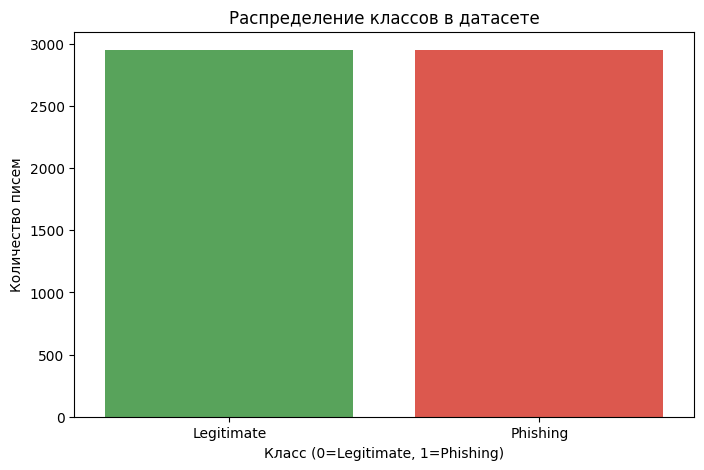


Классы сбалансированы.


In [18]:
# Проверка балансировки классов
import matplotlib.pyplot as plt
import seaborn as sns

class_counts = pd.Series(y).value_counts()
class_percentages = pd.Series(y).value_counts(normalize=True) * 100

print("Распределение классов:")
print(f"  Legitimate (0): {class_counts.get(0, 0)} ({class_percentages.get(0, 0):.2f}%)")
print(f"  Phishing (1): {class_counts.get(1, 0)} ({class_percentages.get(1, 0):.2f}%)")

# Визуализация
plt.figure(figsize=(8, 5))
sns.countplot(x=y, palette=['#4CAF50', '#F44336'])
plt.title('Распределение классов в датасете')
plt.xlabel('Класс (0=Legitimate, 1=Phishing)')
plt.ylabel('Количество писем')
plt.xticks([0, 1], ['Legitimate', 'Phishing'])
plt.show()

# Если классы несбалансированы, можно применить балансировку
if abs(class_percentages.get(0, 0) - class_percentages.get(1, 0)) > 5:
    print("\n Классы несбалансированы. Рекомендуется балансировка.")
else:
    print("\nКлассы сбалансированы.")


## 9. Разделение данных на train/validation/test

Разделение датасета на три части:
- **70%** train — для обучения моделей
- **15%** validation — для подбора гиперпараметров
- **15%** test — для финальной оценки (резерв)

Используется стратифицированное разделение для сохранения пропорций классов.


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

print("Разделение данных завершено:")
print(f"  Train:      {X_train.shape[0]} образцов ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Validation: {X_val.shape[0]} образцов ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  Test:       {X_test.shape[0]} образцов ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nРаспределение классов в train:")
print(f"  Legitimate: {np.sum(y_train == 0)} ({np.sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"  Phishing:   {np.sum(y_train == 1)} ({np.sum(y_train == 1)/len(y_train)*100:.1f}%)")

print(f"\nРаспределение классов в validation:")
print(f"  Legitimate: {np.sum(y_val == 0)} ({np.sum(y_val == 0)/len(y_val)*100:.1f}%)")
print(f"  Phishing:   {np.sum(y_val == 1)} ({np.sum(y_val == 1)/len(y_val)*100:.1f}%)")

print(f"\nРаспределение классов в test:")
print(f"  Legitimate: {np.sum(y_test == 0)} ({np.sum(y_test == 0)/len(y_test)*100:.1f}%)")
print(f"  Phishing:   {np.sum(y_test == 1)} ({np.sum(y_test == 1)/len(y_test)*100:.1f}%)")


Разделение данных завершено:
  Train:      4128 образцов (70.0%)
  Validation: 885 образцов (15.0%)
  Test:       885 образцов (15.0%)

Распределение классов в train:
  Legitimate: 2065 (50.0%)
  Phishing:   2063 (50.0%)

Распределение классов в validation:
  Legitimate: 442 (49.9%)
  Phishing:   443 (50.1%)

Распределение классов в test:
  Legitimate: 443 (50.1%)
  Phishing:   442 (49.9%)


## 10. Сохранение обработанных данных

Сохранение разделенных данных и обученного векторизатора в pickle файлы для использования в `model_training.ipynb`.


In [20]:
# Создание директории для сохранения
MODELS_DIR = BASE_DIR / 'data' / 'models'
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Сохранение train.pkl
print("Сохранение train.pkl...")
with open(MODELS_DIR / 'train.pkl', 'wb') as f:
    pickle.dump({
        'X_train': X_train,
        'y_train': y_train
    }, f)
print(f"✓ train.pkl сохранен: {MODELS_DIR / 'train.pkl'}")

# Сохранение val.pkl
print("Сохранение val.pkl...")
with open(MODELS_DIR / 'val.pkl', 'wb') as f:
    pickle.dump({
        'X_val': X_val,
        'y_val': y_val
    }, f)
print(f"✓ val.pkl сохранен: {MODELS_DIR / 'val.pkl'}")

# Сохранение test.pkl
print("Сохранение test.pkl...")
with open(MODELS_DIR / 'test.pkl', 'wb') as f:
    pickle.dump({
        'X_test': X_test,
        'y_test': y_test
    }, f)
print(f"✓ test.pkl сохранен: {MODELS_DIR / 'test.pkl'}")

# Сохранение обученного TF-IDF векторизатора и scaler
print("Сохранение tfidf_vectorizer.pkl...")
feature_extractor.save_vectorizer(str(MODELS_DIR / 'tfidf_vectorizer.pkl'))
print(f"✓ tfidf_vectorizer.pkl сохранен: {MODELS_DIR / 'tfidf_vectorizer.pkl'}")

print("\nВсе файлы успешно сохранены!")


Сохранение train.pkl...
✓ train.pkl сохранен: C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\models\train.pkl
Сохранение val.pkl...
✓ val.pkl сохранен: C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\models\val.pkl
Сохранение test.pkl...
✓ test.pkl сохранен: C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\models\test.pkl
Сохранение tfidf_vectorizer.pkl...
✓ tfidf_vectorizer.pkl сохранен: C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\models\tfidf_vectorizer.pkl

Все файлы успешно сохранены!


In [21]:
MODELS_DIR = BASE_DIR / 'data' / 'models'

In [22]:
import pickle

with open(MODELS_DIR / 'tfidf_vectorizer.pkl', 'rb') as f:
    vect_data = pickle.load(f)

vectorizer = vect_data['vectorizer']
scaler = vect_data.get('scaler', None)

print("="*40)
print("Параметры tfidf_vectorizer (из файла):")
vocab_size = len(vectorizer.vocabulary_)
print(f"  Размер словаря: {vocab_size}")
print(f"  n_features: {vectorizer.max_features}")
print(f"  min_df: {vectorizer.min_df}")
print(f"  max_df: {vectorizer.max_df}")
print(f"  ngram_range: {vectorizer.ngram_range}")

with open(MODELS_DIR / 'train.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open(MODELS_DIR / 'val.pkl', 'rb') as f:
    val_data = pickle.load(f)
with open(MODELS_DIR / 'test.pkl', 'rb') as f:
    test_data = pickle.load(f)

print("\nРазмерности массивов/датасетов (из файлов):")
print(f"  X_train: {getattr(train_data['X_train'], 'shape', 'нет атрибута shape')}")
print(f"  y_train: {getattr(train_data['y_train'], 'shape', 'нет атрибута shape')}")
print(f"  X_val: {getattr(val_data['X_val'], 'shape', 'нет атрибута shape')}")
print(f"  y_val: {getattr(val_data['y_val'], 'shape', 'нет атрибута shape')}")
print(f"  X_test: {getattr(test_data['X_test'], 'shape', 'нет атрибута shape')}")
print(f"  y_test: {getattr(test_data['y_test'], 'shape', 'нет атрибута shape')}")
print("="*40)

Параметры tfidf_vectorizer (из файла):
  Размер словаря: 5000
  n_features: 5000
  min_df: 2
  max_df: 0.95
  ngram_range: (1, 2)

Размерности массивов/датасетов (из файлов):
  X_train: (4128, 5010)
  y_train: (4128,)
  X_val: (885, 5010)
  y_val: (885,)
  X_test: (885, 5010)
  y_test: (885,)


In [23]:
X_train = train_data['X_train']
y_train = train_data['y_train']
X_val = val_data['X_val']
y_val = val_data['y_val']
X_test = test_data['X_test']
y_test = test_data['y_test']

# Конвертация в sparse matrix
from scipy.sparse import csr_matrix

X_train = csr_matrix(X_train)
X_val = csr_matrix(X_val)
X_test = csr_matrix(X_test)

In [24]:
# Сохранение данных в sparse формате
print("Сохранение train.pkl (sparse format)...")
with open(MODELS_DIR / 'train.pkl', 'wb') as f:
    pickle.dump({
        'X_train': X_train,
        'y_train': y_train
    }, f)
print(f"✓ train.pkl сохранен: {MODELS_DIR / 'train.pkl'}")

print("Сохранение val.pkl (sparse format)...")
with open(MODELS_DIR / 'val.pkl', 'wb') as f:
    pickle.dump({
        'X_val': X_val,
        'y_val': y_val
    }, f)
print(f"✓ val.pkl сохранен: {MODELS_DIR / 'val.pkl'}")

print("Сохранение test.pkl (sparse format)...")
with open(MODELS_DIR / 'test.pkl', 'wb') as f:
    pickle.dump({
        'X_test': X_test,
        'y_test': y_test
    }, f)
print(f"✓ test.pkl сохранен: {MODELS_DIR / 'test.pkl'}")

print("\nВсе файлы успешно сохранены в sparse формате")


Сохранение train.pkl (sparse format)...
✓ train.pkl сохранен: C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\models\train.pkl
Сохранение val.pkl (sparse format)...
✓ val.pkl сохранен: C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\models\val.pkl
Сохранение test.pkl (sparse format)...
✓ test.pkl сохранен: C:\Users\huzch\Documents\project\eml-phishing-analyzer\data\models\test.pkl

Все файлы успешно сохранены в sparse формате


In [25]:
print(f"Тип X_train: {type(X_train)}")
print(f"Формат: {X_train.__class__.__name__}")

Тип X_train: <class 'scipy.sparse._csr.csr_matrix'>
Формат: csr_matrix


In [25]:
from scipy.sparse import issparse, csr_matrix


In [26]:
issparse(X_train)

True

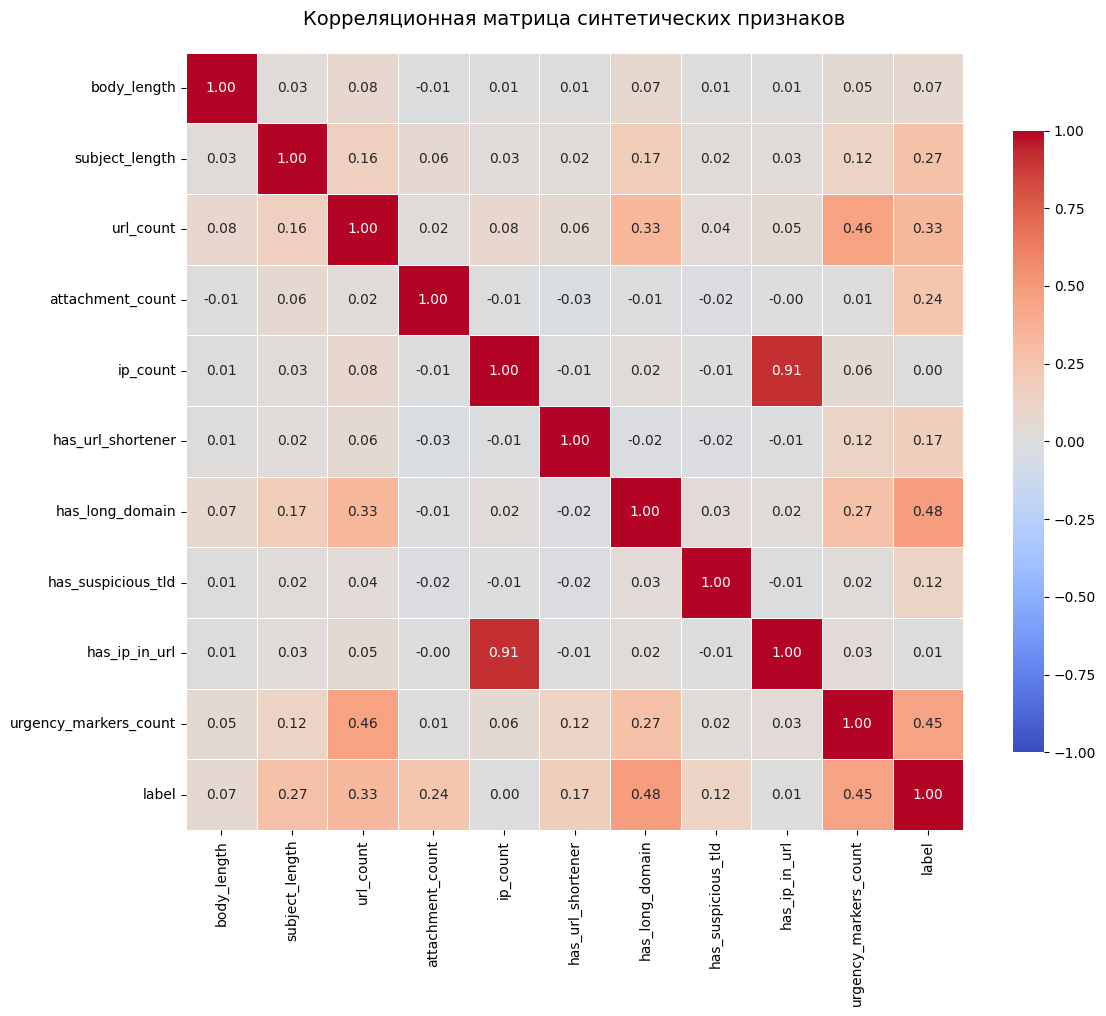


АНАЛИЗ КОРРЕЛЯЦИЙ

Пары признаков с высокой корреляцией (|r| > 0.5):
--------------------------------------------------------------------------------
  ip_count ↔ has_ip_in_url: 0.908

--------------------------------------------------------------------------------
Корреляция признаков с целевой переменной (label):
--------------------------------------------------------------------------------
  has_long_domain          :   0.484
  urgency_markers_count    :   0.452
  url_count                :   0.326
  subject_length           :   0.272
  attachment_count         :   0.236
  has_url_shortener        :   0.167
  has_suspicious_tld       :   0.123
  body_length              :   0.069
  has_ip_in_url            :   0.013
  ip_count                 :   0.000



In [26]:
# Корреляционная матрица для синтетических признаков
import matplotlib.pyplot as plt
import seaborn as sns

# Выбираем только числовые признаки для корреляционной матрицы
numeric_features = [
    'body_length',
    'subject_length',
    'url_count',
    'attachment_count',
    'ip_count',
    'has_url_shortener',
    'has_long_domain',
    'has_suspicious_tld',
    'has_ip_in_url',
    'urgency_markers_count',
    'label'
]

# Создаем подмножество датафрейма с числовыми признаками
df_corr = df_features[numeric_features]

# Вычисляем корреляционную матрицу
correlation_matrix = df_corr.corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    vmin=-1,
    vmax=1
)
plt.title('Корреляционная матрица синтетических признаков', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Выводим статистику корреляций
print("\n" + "="*80)
print("АНАЛИЗ КОРРЕЛЯЦИЙ")
print("="*80)

# Находим пары признаков с высокой корреляцией (|r| > 0.5)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.5:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                corr_value
            ))

if high_corr_pairs:
    print("\nПары признаков с высокой корреляцией (|r| > 0.5):")
    print("-" * 80)
    for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"  {feat1} ↔ {feat2}: {corr:.3f}")
else:
    print("\nНет пар признаков с высокой корреляцией (|r| > 0.5)")

# Корреляция признаков с целевой переменной (label)
print("\n" + "-" * 80)
print("Корреляция признаков с целевой переменной (label):")
print("-" * 80)
label_correlations = correlation_matrix['label'].drop('label').sort_values(key=abs, ascending=False)
for feature, corr in label_correlations.items():
    print(f"  {feature:25s}: {corr:7.3f}")

print("\n" + "="*80)
